Epoch 1/50


/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.3128e-04
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.3581e-06
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.3464e-06
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.9022e-06
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.4923e-06
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.3590e-06
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.0774e-06
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.2409e-06
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.2460e-06
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.3512e-06
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.9552e-06
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.4979e-06
Epoch 13/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.4745e-06
Epoch 14/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.6220e-06
Epoch 15/50
69/69 ━━━━━━━━

/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.4051e-04
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.8571e-06
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.4078e-06
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.9708e-06
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4.4939e-06
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.6231e-06
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.2280e-06
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.3605e-06
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.1581e-06
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.2348e-06
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.4163e-06
Epoch 12/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.1425e-06
Epoch 13/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.3609e-06
Epoch 14/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.4673e-06
Epoch 15/50
71/71 ━━━━━━━━

/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 2.4061e-04
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.7254e-06
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.4991e-06
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.3832e-06
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.2323e-06
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.0893e-06
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.3470e-05
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.7240e-06
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.4385e-06
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.3248e-06
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.6517e-06
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.7186e-06
Epoch 13/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.5016e-06
Epoch 14/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.4693e-06
Epoch 15/50
74/74 ━━━━━━━━

/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.3098e-04
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.9497e-06
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.2044e-06
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.1282e-06
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.2679e-06
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.6470e-06
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.2184e-06
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.7570e-06
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.3439e-06
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.8412e-06
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.3479e-06
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.0461e-06
Epoch 13/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.3198e-06
Epoch 14/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.0603e-06
Epoch 15/50
76/76 ━━━━━━━━

/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.0880e-04
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.7264e-06
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.5759e-06
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.8633e-06
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.9619e-06
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.1720e-06
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.1061e-06
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.9102e-06
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.1596e-06
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.1304e-06
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.7385e-06
Epoch 12/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 4.3094e-06
Epoch 13/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.8141e-06
Epoch 14/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.7623e-06
Epoch 15/50
78/78 ━━━━━━━━

/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 3.0599e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.2944e-06
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.7746e-06
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.3424e-06
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.7676e-06
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.3340e-06
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6311e-06
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.6999e-06
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.3583e-06
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.5805e-06
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.8981e-06
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.1018e-06
Epoch 13/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.3654e-06
Epoch 14/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.2117e-06
Epoch 15/50
81/81 ━━━━━━━━

/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.9493e-04
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.3214e-06
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.4720e-06
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.3610e-06
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.2272e-06
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.5453e-06
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.3864e-06
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.9963e-06
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.2057e-06
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.7881e-06
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.5755e-06
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 6.2222e-06
Epoch 13/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.4456e-06
Epoch 14/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.0359e-06
Epoch 15/50
83/83 ━━━━━━━━

/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.5402e-04
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.6645e-06
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.1216e-06
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.3533e-06
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.5142e-06
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.7643e-06
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.3413e-06
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.5927e-06
Epoch 9/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6691e-06
Epoch 10/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.8562e-06
Epoch 11/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.4021e-06
Epoch 12/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.7422e-06
Epoch 13/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.9826e-06
Epoch 14/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.2392e-06
Epoch 15/50
86/86 ━━━━━━━━

/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.7816e-04
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.3168e-06
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.6441e-06
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.0438e-06
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.8628e-06
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.7612e-06
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.2214e-06
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6441e-06
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.8307e-06
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.8615e-06
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.0878e-06
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.4386e-06
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.3759e-06
Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.5201e-06
Epoch 15/50
88/88 ━━━━━━━━

/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.7694e-04
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0545e-05
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.4034e-05
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5988e-05
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.9028e-05
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7.3650e-06
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.3352e-06
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.0749e-06
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.6038e-06
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.3202e-06
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.1736e-06
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.9421e-06
Epoch 13/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.9247e-06
Epoch 14/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7291e-06
Epoch 15/50
91/91 ━━━━━━━━━━

/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.3151e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.0000e-05
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.7609e-05
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1188e-05
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5140e-05
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3605e-05
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.7510e-06
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.2022e-05
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.1980e-05
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0684e-05
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 9.4531e-06
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.1827e-05
Epoch 13/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.7059e-06
Epoch 14/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.8574e-06
Epoch 15/50
93/93 ━━━━━━━━━━━

/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.4001e-04
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4463e-05
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5251e-05
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.7114e-05
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6297e-05
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4093e-05
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2751e-05
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7288e-05
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4581e-05
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2255e-05
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7778e-05
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5786e-05
Epoch 13/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5007e-05
Epoch 14/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0534e-05
Epoch 15/50
96/96 ━━━━━━━━━━━━━━━━━━━━

/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.9475e-04
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.6211e-05
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1025e-05
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.7462e-05
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1754e-04
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.9691e-05
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9383e-05
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.7273e-05
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.4452e-05
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9746e-05
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.4918e-05
Epoch 12/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.0064e-05
Epoch 13/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0475e-05
Epoch 14/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.7480e-05
Epoch 15/50
98/98 ━━━━━━━━━

/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0020
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.5313e-04
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2083e-04
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2613e-04
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.4346e-05
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.6206e-05
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3666e-05
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0814e-04
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.8114e-05
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 7.3949e-05
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.7198e-04
Epoch 12/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.5489e-05
Epoch 13/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.5340e-05
Epoch 14/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.1663e-05
Ep

/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0050
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.5256e-04
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.5641e-04
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3885e-04
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7273e-04
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8732e-04
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.1930e-04
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6200e-04
Epoch 9/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.1714e-04
Epoch 10/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8675e-04
Epoch 11/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5233e-04
Epoch 12/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0383e-04
Epoch 13/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.0492e-04
Epoch 14/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.3558e-04
Ep

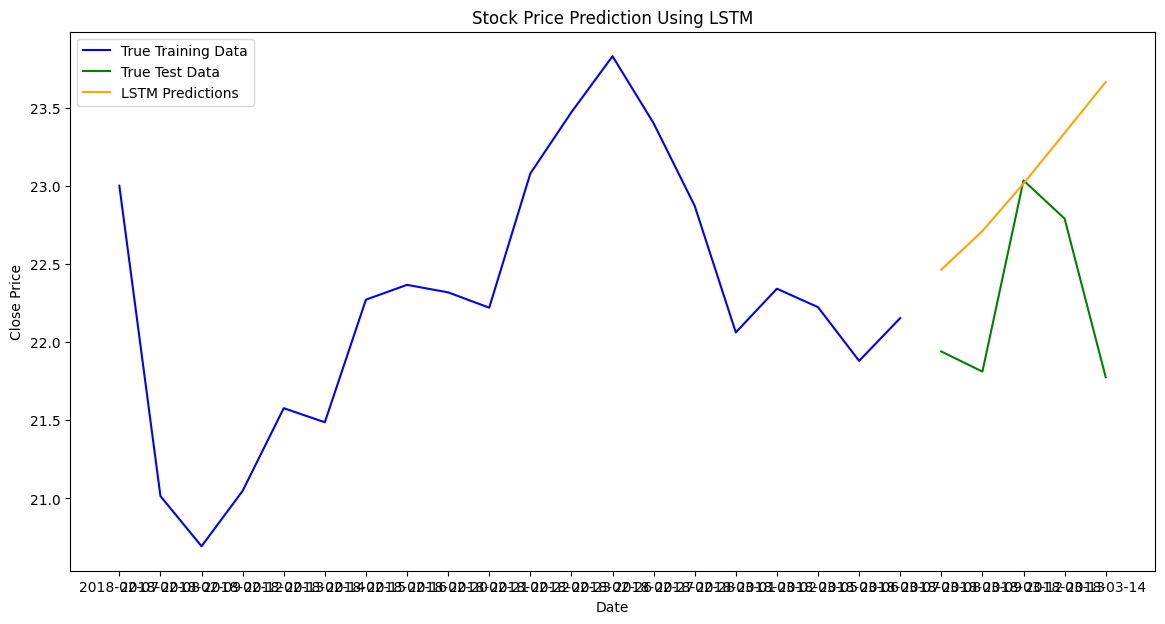

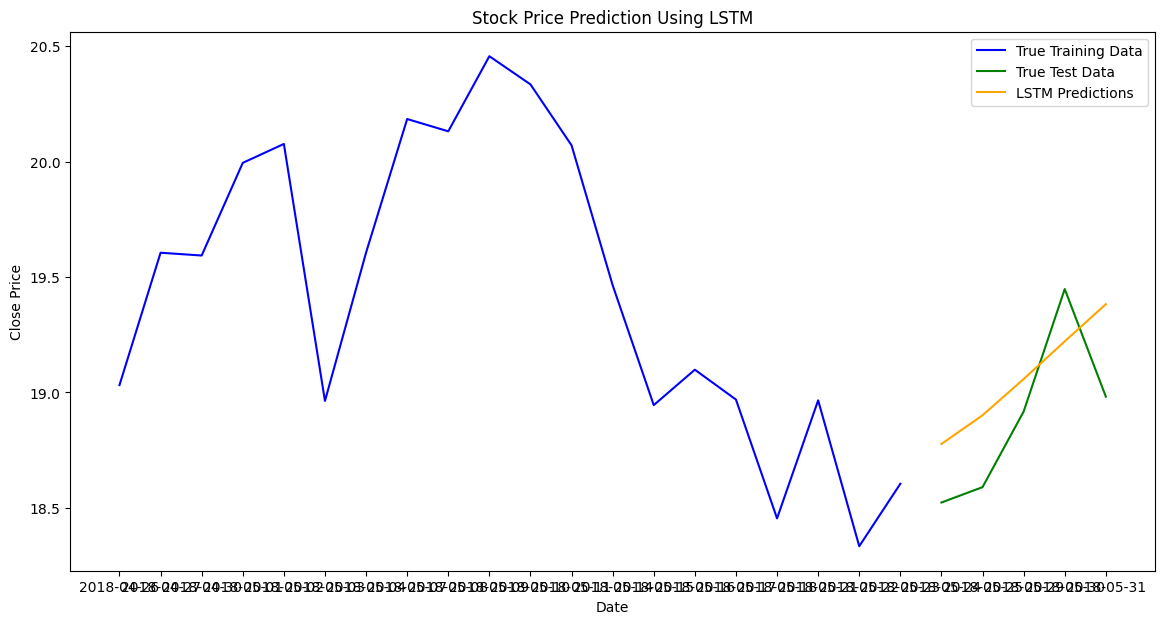

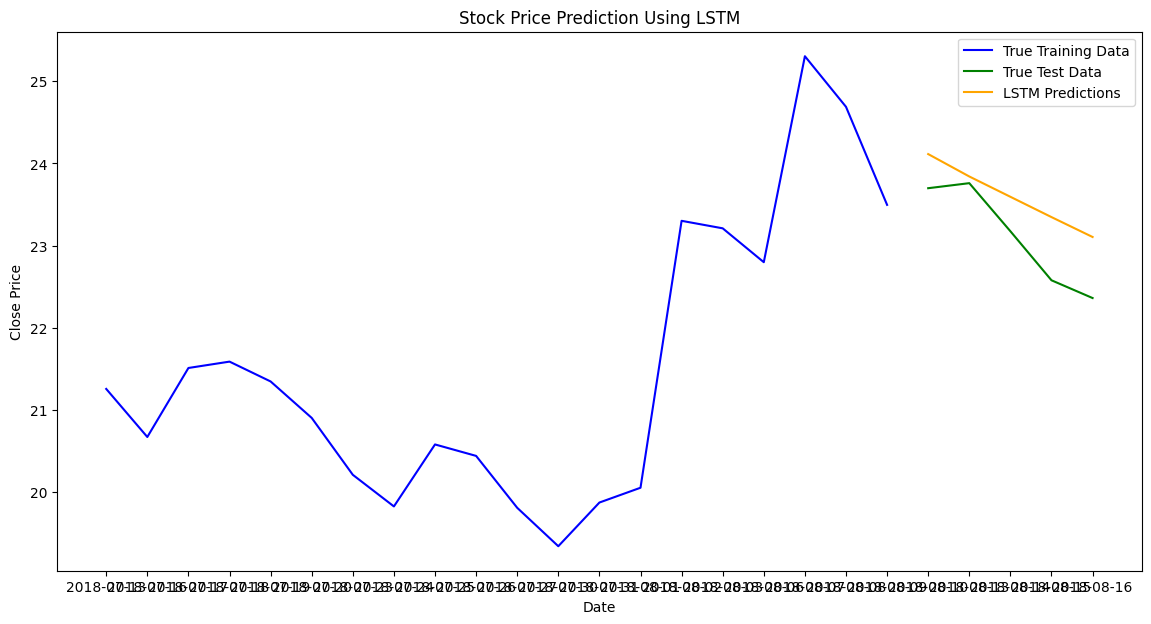

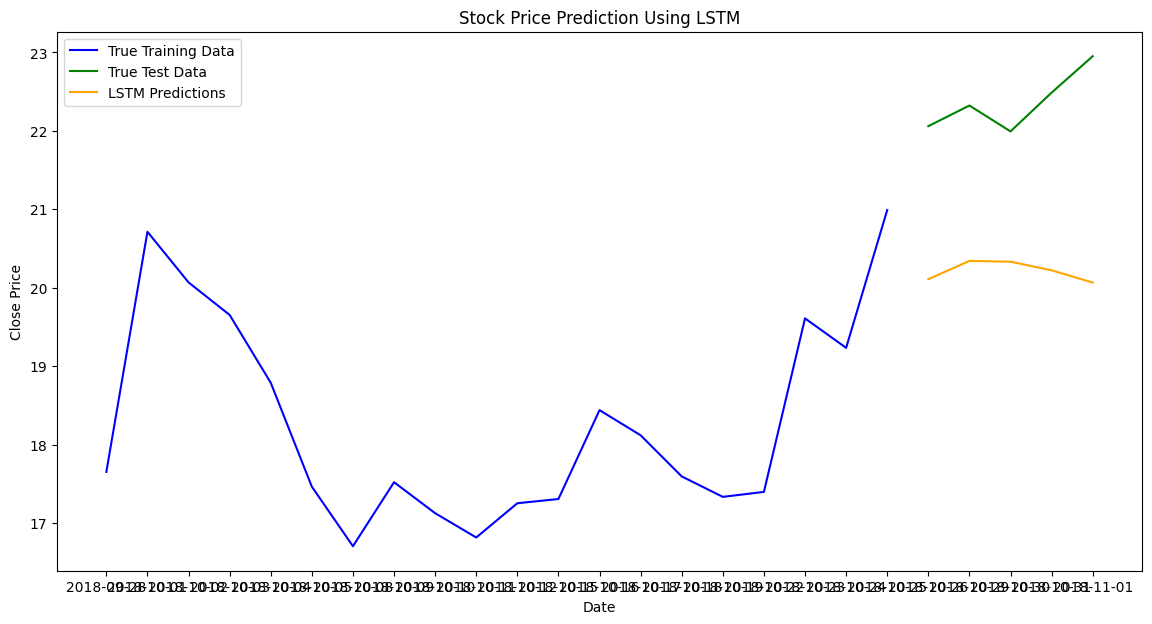

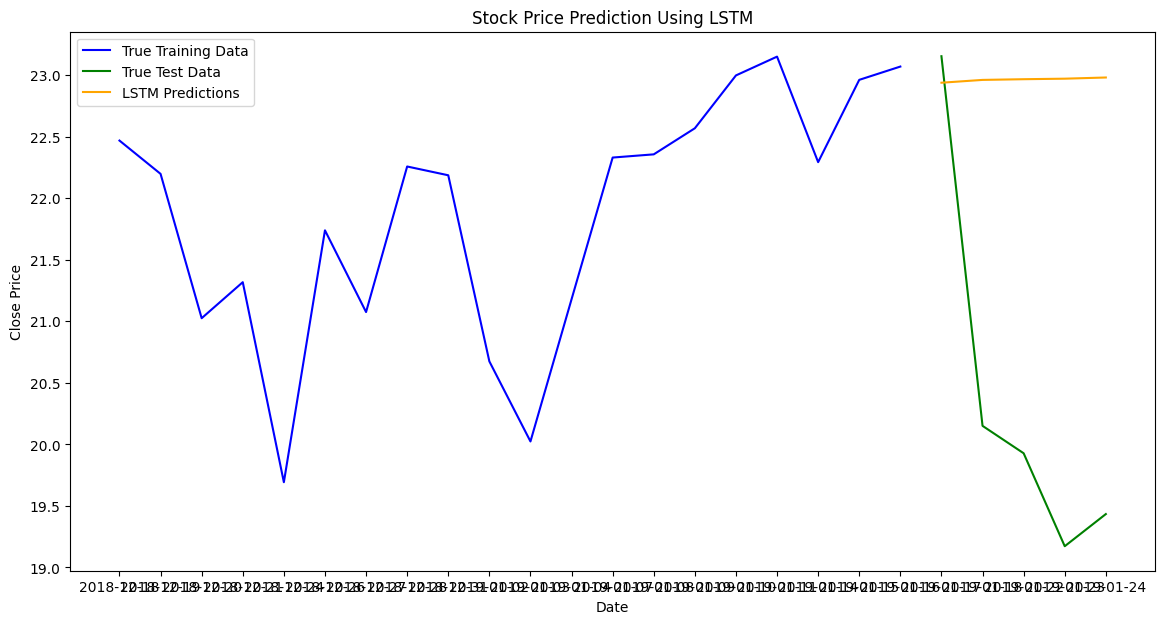

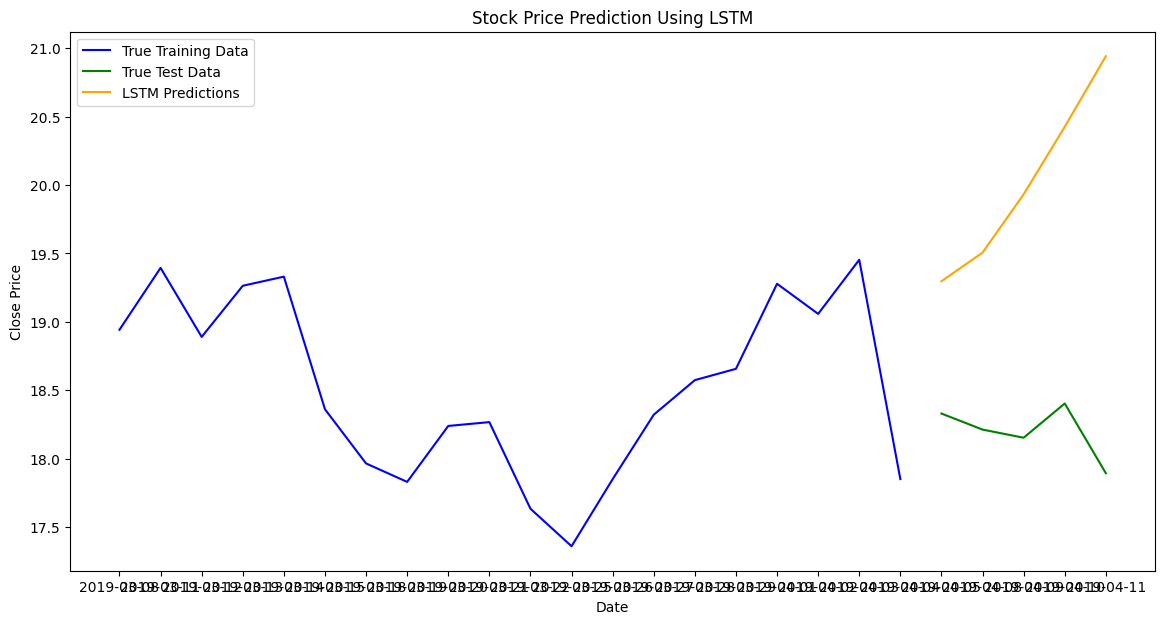

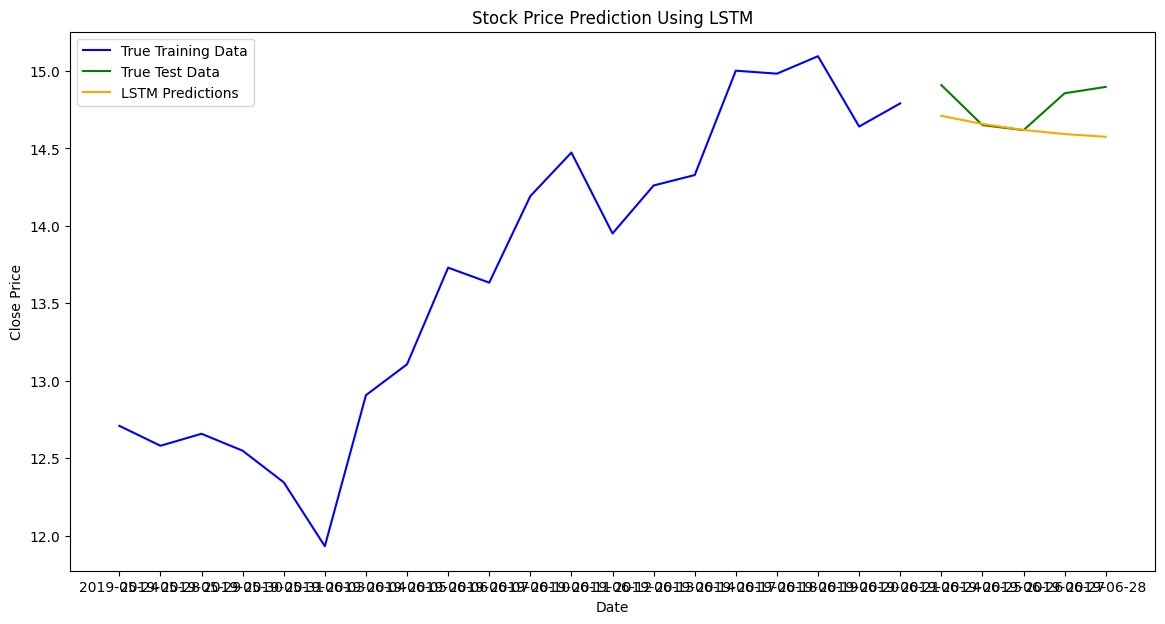

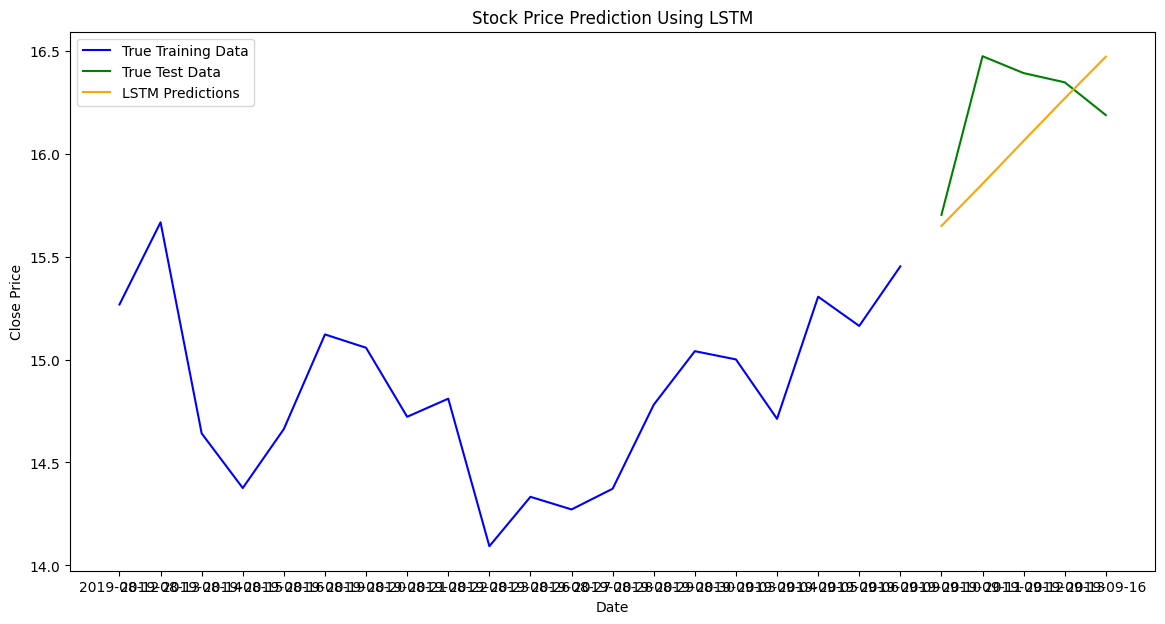

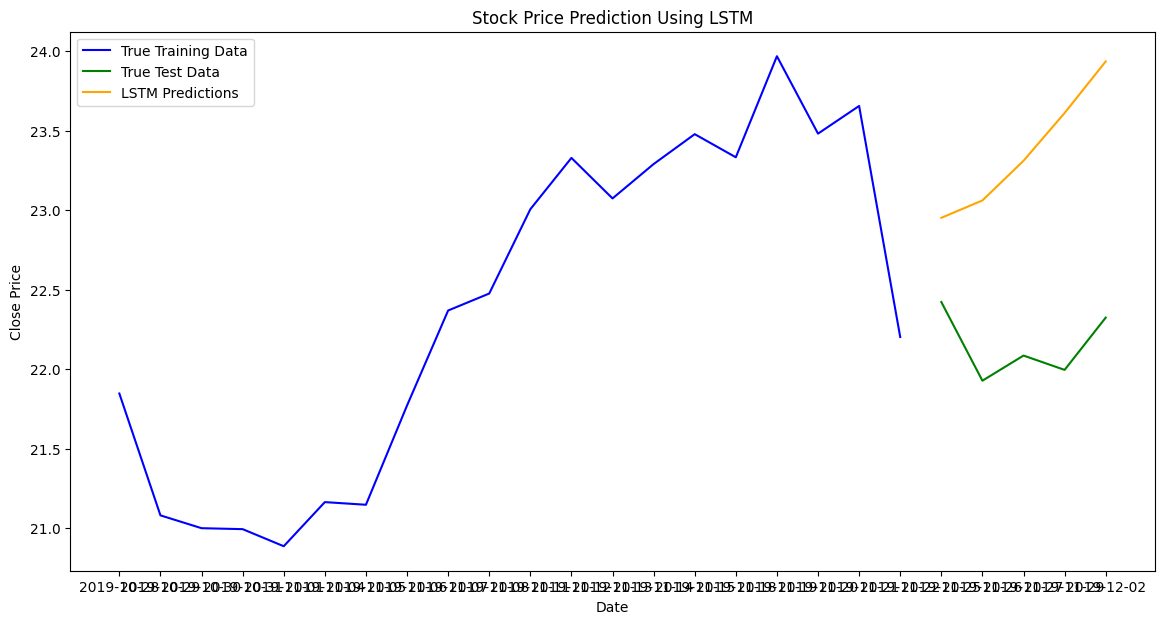

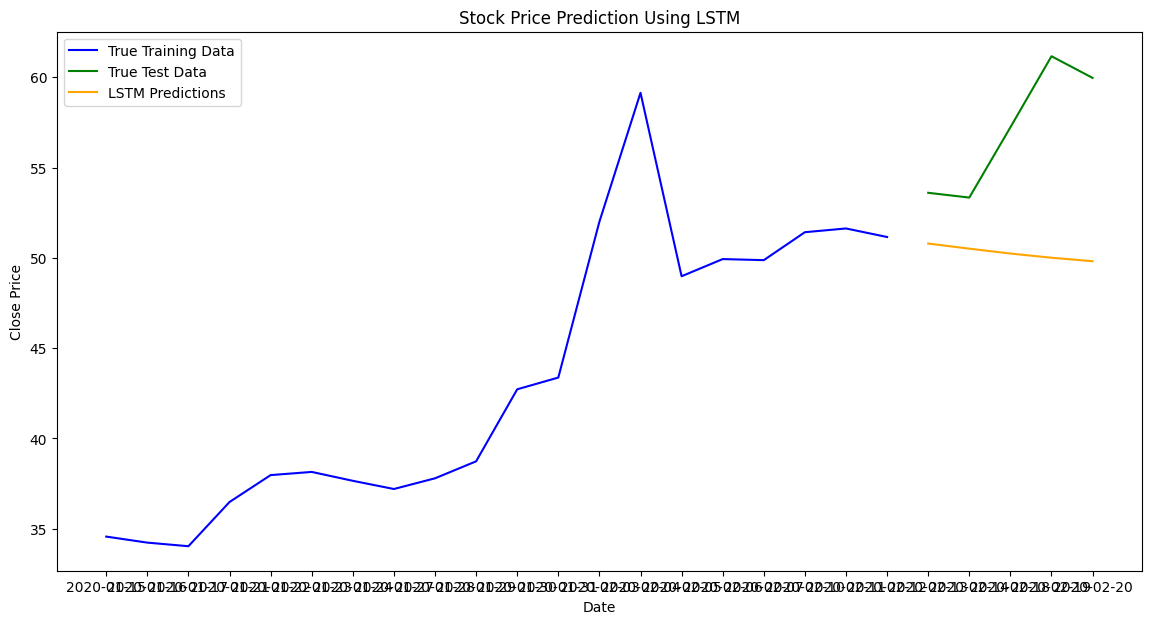

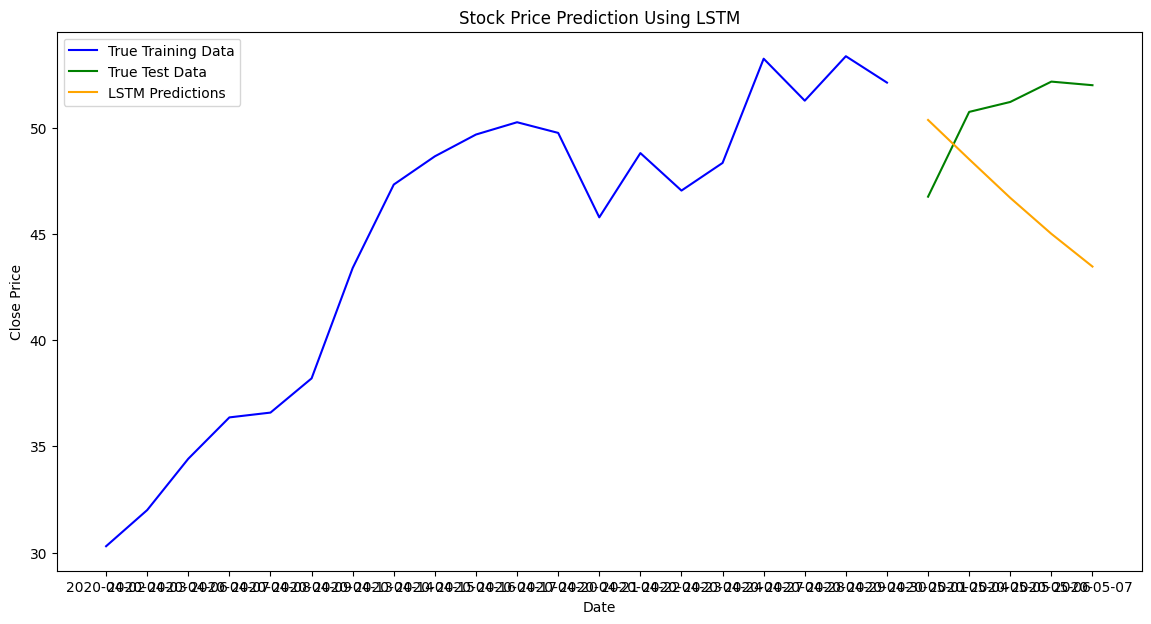

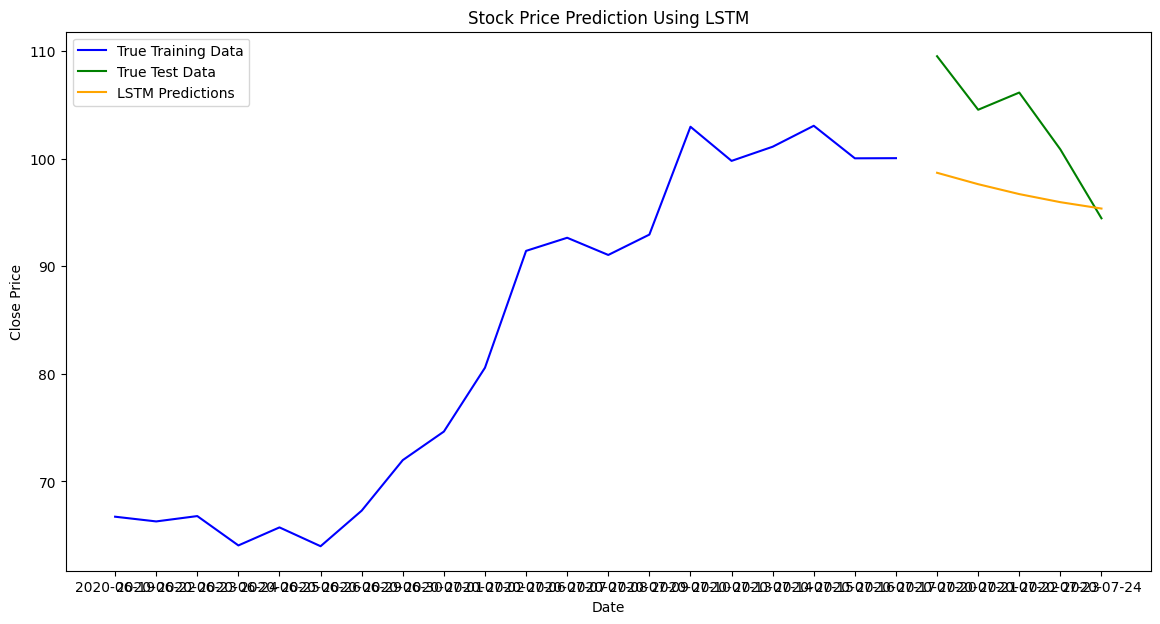

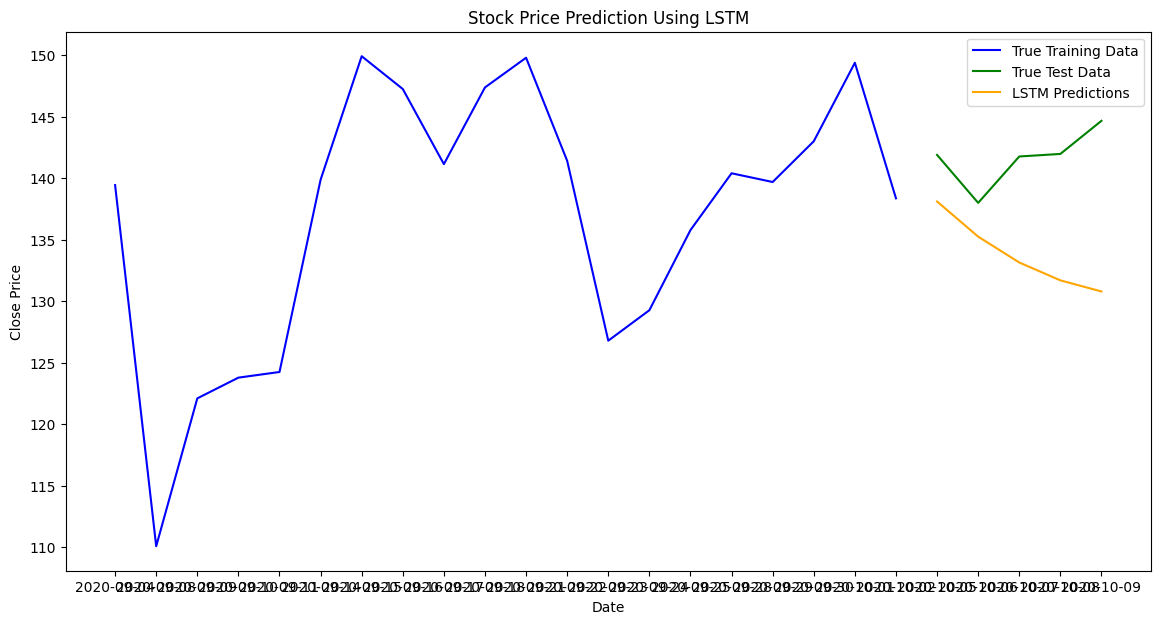

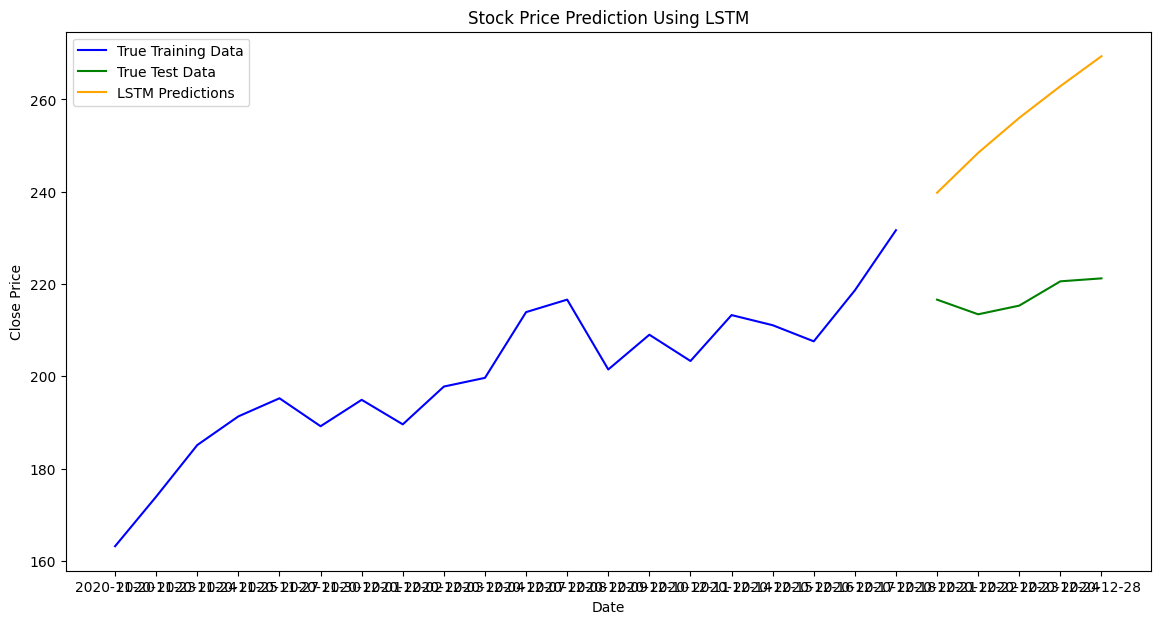

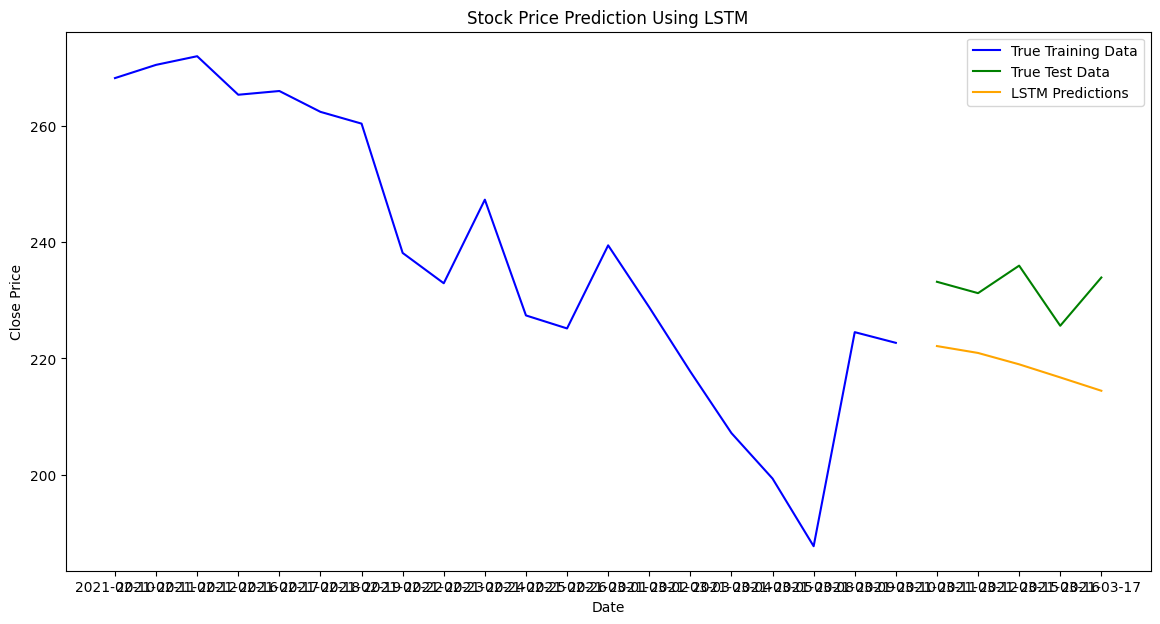

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import os
import math
from keras.layers import GRU  # Import GRU layer

def m(p):
    n_days_to_predict = 5  # Number of days to predict ahead
    training_period = 15  # Number of days to use as input for LSTM
    path = "TSLA.csv"  # Path to your stock data file

    # Load and preprocess the dataset
    headers = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
    df = pd.read_csv(path, names=headers, skiprows=1)  # Skip the header
    df.replace("null", np.nan, inplace=True)
    df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(float)
    df.set_index("Date", inplace=True)

    # Filter the 'Close' column (target variable)
    data = df.filter(['Close'])
    dataset = data.values

    # Normalize the dataset using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    t = math.ceil(len(scaled_data)*p)
    
    # Create the training data using historical data
    x_train, y_train = [], []

    for i in range(training_period, t):
        x_train.append(scaled_data[i - training_period:i, 0])
        y_train.append(scaled_data[i, 0])

    # Convert the lists into numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the input to be [samples, time steps, features]
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

    # Step 1: Build and train the LSTM-GRU model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))  # LSTM layer
    model.add(GRU(units=50, return_sequences=False))  # Add GRU layer
    model.add(Dense(units=25))  # Dense layer to reduce complexity
    model.add(Dense(units=1))  # Output layer

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=22, epochs=50)
    
    # Step 2: Make predictions
    x_test = scaled_data[-training_period+t:t].reshape(1, -1, 1)
    predictions = []

    for i in range(n_days_to_predict):
        lstm_pred = model.predict(x_test)
        lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)
        predictions.append(lstm_pred_rescaled[0, 0])
        x_test = np.append(x_test[:, 1:, :], lstm_pred.reshape(1, 1, 1), axis=1)

    # Step 3: Visualize the predictions
    plt.figure(figsize=(14, 7))
    plt.plot(data.index[t-20:t], scaler.inverse_transform(scaled_data[t-20:t]), label='True Training Data', color='blue')
    y_test_rescaled = scaler.inverse_transform(scaled_data[t:t+n_days_to_predict])
    plt.plot(data.index[t:t+n_days_to_predict], y_test_rescaled, label='True Test Data', color='green')
    plt.plot(data.index[t:t+n_days_to_predict], predictions, label='LSTM-GRU Predictions', color='orange')

    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Stock Price Prediction Using LSTM-GRU')
    plt.legend()
    plt.savefig(f"TSLA_pred/15_5/{p}.png")

# Call the function for different percentages
for p in np.linspace(0.60, 0.9, 15):
    m(p)


In [3]:
scaler.inverse_transform(scaled_data[len(x_train)-20:len(x_train)])[-3:]

NameError: name 'scaler' is not defined